In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.io as sio
import seaborn as sns
import os
import h5py
from PIL import Image
from pathlib import Path
from scipy import signal, interpolate, stats
from tkinter import filedialog, simpledialog
from tkinter import *
import ptitprince as pt
import re
root = Tk()
root.withdraw()

mat_filenames =  filedialog.askopenfilename(title = "Select Fall.mat files", filetypes = (("Mat files","*Fall.mat"),), multiple = True)
#mouse_name = simpledialog.askstring("Mouse name", "Enter mouse name:")    

''

In [66]:
def load_mouse(mat_filenames):
    
    dff_list = []
    session_list = []
    peaks_list = []
    widths_list = []
    ph_list = []
    skew_list = []

    avg_array = np.zeros([5,11])
    avg_array[avg_array == 0] = np.NaN

    i = 0

    for j in range(0,len(mat_filenames)):
        mat = sio.loadmat(mat_filenames[j])
        iscell = mat['iscell']
        #Load calcium data and iscell binary list from concatenated s2p run
        F = mat['F']
        stat = mat['stat']
        #Find integer for session
        ses_num = re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", mat_filenames[j])
        ses_num = int(ses_num[2])

        #Select real cells and normalize raw calcium signal
        #Need to convert iscell to array? Probably just being stupid
        x = iscell[:,0].astype(bool)

        F_real = F[x == 1,:]
        stat_real = stat[0][x == 1]
        F_real[F_real == 0] = np.nan
        sesF_dff = []
        sespeaks = []
        seswidths = []
        sesheights = []
        sesskew = []
        #Get dimensions of real cell data
        for iter, data in enumerate(F_real):
            F_dff = stats.zscore(data)
            #F0 = np.percentile(data, 1)
            #F_dff = (data - F0)/F0
            peaks, heights= signal.find_peaks(F_dff, height=0.5, distance=7)
            widths = signal.peak_widths(F_dff, peaks, rel_height=0.5)

            sesskew.append(stat_real[iter]['skew'])
            sesF_dff.append(F_dff)
            sespeaks.append(len(peaks))
            seswidths.append(np.mean(widths[0]))
            sesheights.append(np.mean(heights['peak_heights']))
        dff_list.append(sesF_dff)
        peaks_list.append(sespeaks)
        widths_list.append(seswidths)
        skew_list.append(sesskew)
        ph_list.append(sesheights)
        session_list.append(np.repeat(ses_num, len(sespeaks)))
        ses_num = ses_num - 1
        avg_array[0,ses_num] = len(F_real)
        avg_array[1,ses_num] = np.mean(sespeaks)
        avg_array[2,ses_num] = np.mean(seswidths) * 0.0645
        avg_array[3,ses_num] = np.percentile(sesheights,95)
        if len(sesskew) > 1:
            avg_array[4,ses_num] = np.percentile(np.array(sesskew, dtype='float64'),95)

        i = i + 1
        #Make a dictionary
    


    
    #return dff_list, peaks_list, widths_list, ph_list, session_list
    return avg_array

In [67]:
num_mice = simpledialog.askinteger("Number of animals","Number of animals:")

avg_list = []

for i in range(num_mice):
    output = load_mouse()
    avg_list.append(output)
    #print(output)

c:\Users\tomva\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\tomva\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [68]:
x = np.stack(avg_list, axis=2)
y = np.nanmean(x,axis=2)
#print(y)

<ipython-input-68-bd218ffd4f36>:2: RuntimeWarning: Mean of empty slice
  y = np.nanmean(x,axis=2)


In [69]:
to_write = np.stack(avg_list, axis=0)
print(np.shape(to_write))

(8, 5, 11)


In [56]:
sname = 'Evoked' 

In [73]:
sname = 'Spontaneous'

In [9]:
y[0,:]

array([229.375     , 216.71428571, 216.125     , 147.        ,
                nan,  46.33333333, 117.2       ,  86.57142857,
       123.71428571, 171.83333333, 156.57142857])

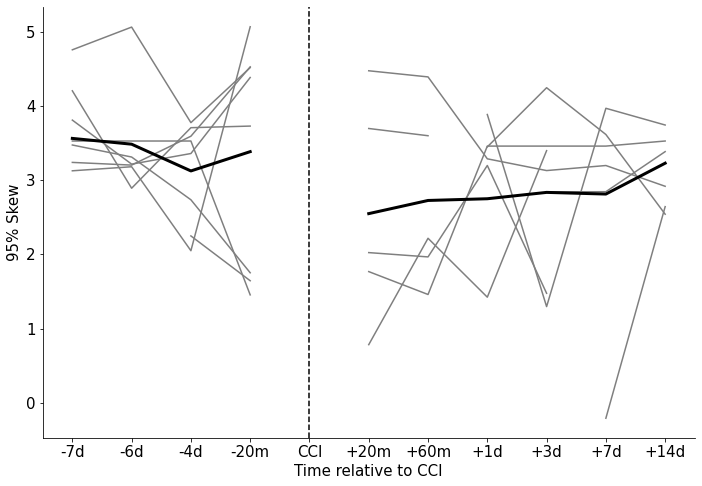

In [74]:
plt.rc('font', size=15)


fig, ax =  plt.subplots(figsize=(10,7))
im = ax.plot(x[4,:,:],'tab:grey')
ax.plot(y[4,:],'k',lw=3)
plt.ylabel('95% Skew')
plt.xlabel('Time relative to CCI')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.axvline(x=4, color='black', linestyle='--')
x_label_list = ['-7d','-6d','-4d','-20m','CCI','+20m','+60m','+1d','+3d','+7d','+14d']
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
ax.set_xticklabels(x_label_list)
fig.tight_layout()
plt.savefig('{}_averageskewofskew.eps'.format(sname))
plt.show()

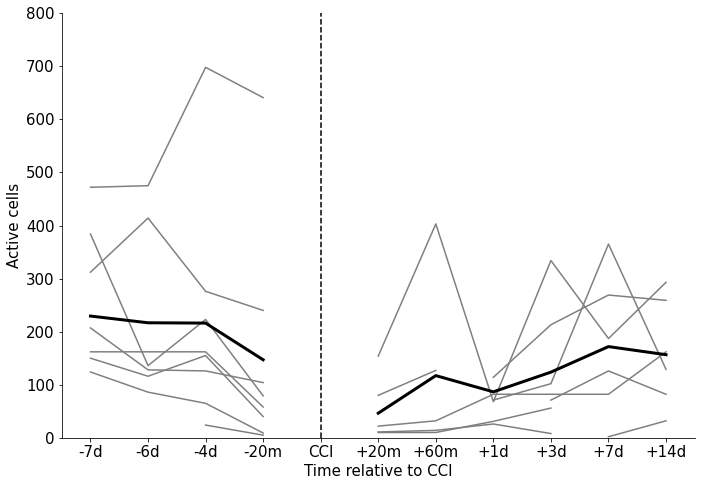

In [10]:
plt.rc('font', size=15)


fig, ax =  plt.subplots(figsize=(10,7))
im = ax.plot(x[0,:,:],'tab:grey')
ax.plot(y[0,:],'k',lw=3)
plt.ylabel('Active cells')
plt.xlabel('Time relative to CCI')
plt.ylim(0,800)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.axvline(x=4, color='black', linestyle='--')
x_label_list = ['-7d','-6d','-4d','-20m','CCI','+20m','+60m','+1d','+3d','+7d','+14d']
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
ax.set_xticklabels(x_label_list)
fig.tight_layout()
plt.savefig('{}_activecells.eps'.format(sname))
plt.show()

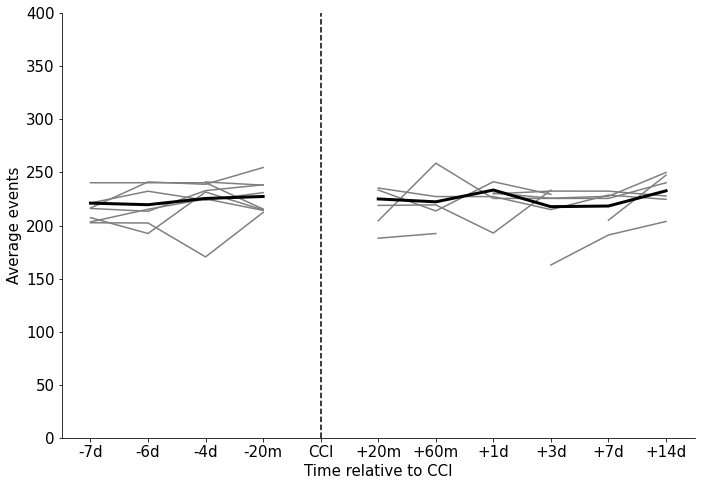

In [8]:
fig, ax =  plt.subplots(figsize=(10,7))
im = ax.plot(x[1,:,:],'tab:grey')
ax.plot(y[1,:],'k',lw=3)
plt.ylabel('Average events')
plt.xlabel('Time relative to CCI')
plt.ylim(0,400)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.axvline(x=4, color='black', linestyle='--')
x_label_list = ['-7d','-6d','-4d','-20m','CCI','+20m','+60m','+1d','+3d','+7d','+14d']
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
ax.set_xticklabels(x_label_list)
fig.tight_layout()
plt.savefig('{}_averageevents.eps'.format(sname))
plt.show()

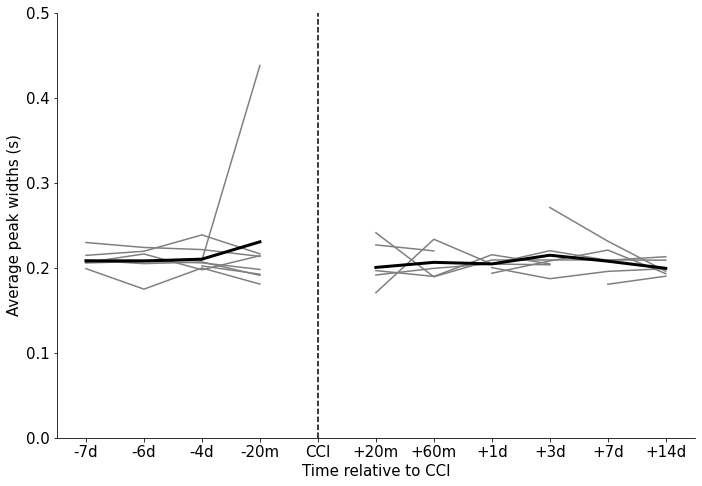

In [9]:
fig, ax =  plt.subplots(figsize=(10,7))
im = ax.plot(x[2,:,:],'tab:grey')
ax.plot(y[2,:],'k',lw=3)
plt.ylabel('Average peak widths (s)')
plt.xlabel('Time relative to CCI')
plt.ylim(0,0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.axvline(x=4, color='black', linestyle='--')
x_label_list = ['-7d','-6d','-4d','-20m','CCI','+20m','+60m','+1d','+3d','+7d','+14d']
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
ax.set_xticklabels(x_label_list)
fig.tight_layout()
plt.savefig('{}_averageeventwidths.eps'.format(sname))
plt.show()

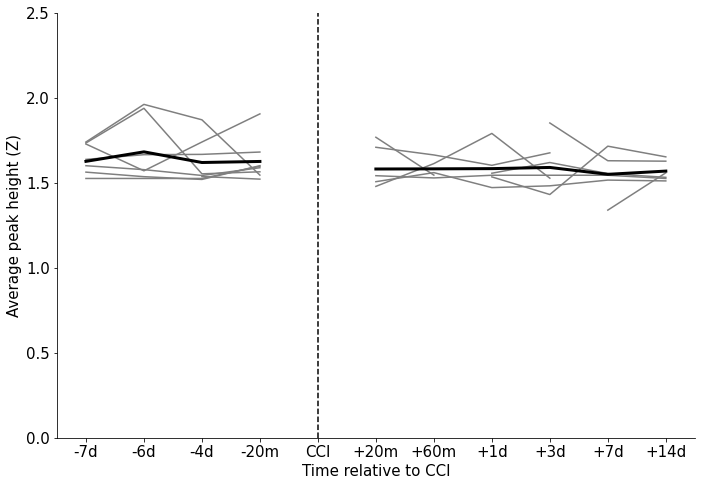

In [72]:
fig, ax =  plt.subplots(figsize=(10,7))
im = ax.plot(x[3,:,:],'tab:grey')
ax.plot(y[3,:],'k',lw=3)
plt.ylabel('Average peak height (Z)')
plt.xlabel('Time relative to CCI')
plt.ylim(0,2.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.axvline(x=4, color='black', linestyle='--')
x_label_list = ['-7d','-6d','-4d','-20m','CCI','+20m','+60m','+1d','+3d','+7d','+14d']
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
ax.set_xticklabels(x_label_list)
fig.tight_layout()
plt.savefig('{}_averageeventheights.eps'.format(sname))
plt.show()

In [1]:
 mat_filenames =  filedialog.askopenfilename(title = "Select Fall.mat files", filetypes = (("Mat files","*Fall.mat"),), multiple = True)

dff_list = []
session_list = []
peaks_list = []
widths_list = []
ph_list = []

avg_array = np.zeros([5,11])

i = 0

for j in range(0,len(mat_filenames)):
    mat = sio.loadmat(mat_filenames[j])
    iscell = mat['iscell']
    #Load calcium data and iscell binary list from concatenated s2p run
    F = mat['F']
    skew = mat['skew']
    #Find just the integer in the filename
    ses_num = re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", mat_filenames[j])
    ses_num = int(ses_num[2])

    #Select real cells and normalize raw calcium signal
    #Need to convert iscell to array? Probably just being stupid
    x = iscell[:,0].astype(bool)

    F_real = F[x == 1,:]
    F_real[F_real == 0] = np.nan
    sesF_dff = []
    sespeaks = []
    seswidths = []
    sesheights = []
    #Get dimensions of real cell data
    for data in F_real:
        #F_dff = stats.zscore(data)
        F0 = np.percentile(data, 10)
        F_dff = (data - F0)/F0
        peaks, heights= signal.find_peaks(F_dff, height=0.2, distance=7)
        widths = signal.peak_widths(F_dff, peaks, rel_height=0.5)

        sesF_dff.append(F_dff)
        sespeaks.append(len(peaks))
        seswidths.append(np.mean(widths[0]))
        sesheights.append(np.mean(heights['peak_heights']))
    dff_list.append(sesF_dff)
    peaks_list.append(sespeaks)
    widths_list.append(seswidths)
    ph_list.append(sesheights)
    session_list.append(np.repeat(ses_num, len(sespeaks)))
    ses_num = ses_num - 1
    avg_array[0,ses_num] = len(F_real)
    avg_array[1,ses_num] = np.mean(sespeaks)
    avg_array[2,ses_num] = np.mean(seswidths) * 0.0645
    avg_array[3,ses_num] = np.mean(sesheights)

    i = i + 1

print(avg_array)

NameError: name 'np' is not defined

In [ ]:
#Need to make a dataframe 

In [95]:
dff_list

[[array([ 0.08920047,  0.13667904, -0.05732138, ...,  0.09135499,
          0.15569872,  0.47340688], dtype=float32),
  array([0.30509833, 0.46289366, 0.30186453, ..., 0.49442557, 0.4499736 ,
         0.45817098], dtype=float32),
  array([ 0.11750622,  0.12542656,  0.07735942, ..., -0.02965557,
          0.23122717,  0.17944014], dtype=float32),
  array([0.06202567, 0.08922877, 0.684202  , ..., 0.40830588, 0.55275434,
         0.6695635 ], dtype=float32),
  array([0.70287365, 0.45799777, 0.5197369 , ..., 0.3026685 , 0.25914305,
         0.0483967 ], dtype=float32),
  array([-0.0631669 ,  0.04819207,  0.18466055, ...,  0.38888508,
          0.22882788,  0.1750371 ], dtype=float32),
  array([ 0.1783749 ,  0.06366146,  0.11512259, ...,  0.2077373 ,
          0.20579311, -0.00638832], dtype=float32),
  array([0.3542759 , 0.07993907, 0.16545595, ..., 0.15378705, 0.45586085,
         0.26271412], dtype=float32),
  array([0.32590824, 0.13828796, 0.31411758, ..., 0.3424494 , 0.27641943,
      

In [46]:
avg_array[1,:]

array([ 74.32371795,  73.18115942,  83.6884058 ,  89.02083333,
         0.        , 102.8       ,  71.3       , 100.5483871 ,
        79.58928571,   0.        ,  81.1294964 ])

In [14]:
load_mouse()

ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (9).

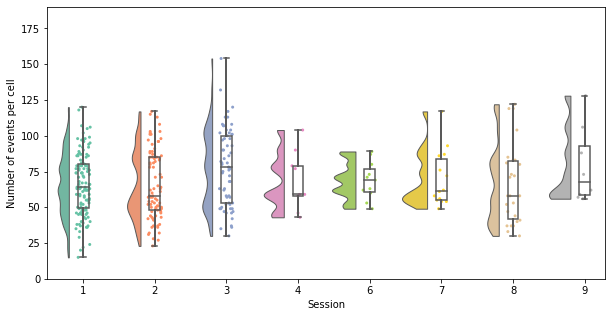

In [14]:
# Usage with a list/np.array input
dx = np.concatenate(session_list)
dy = np.concatenate(peaks_list)
f, ax = plt.subplots(figsize=(10, 5))
ax=pt.RainCloud(dx, dy)

plt.ylabel('Number of events per cell')
plt.xlabel('Session')
plt.ylim(0,190)
x_label_list = ['B1','B2','B3','C4','T6','T7','T8','T9','T11']
ax.set_xticklabels(x_label_list)

[Text(0, 0, 'B1'),
 Text(1, 0, 'B2'),
 Text(2, 0, 'B3'),
 Text(3, 0, 'C4'),
 Text(4, 0, 'T6'),
 Text(5, 0, 'T7'),
 Text(6, 0, 'T8'),
 Text(7, 0, 'T9'),
 Text(8, 0, 'T11')]

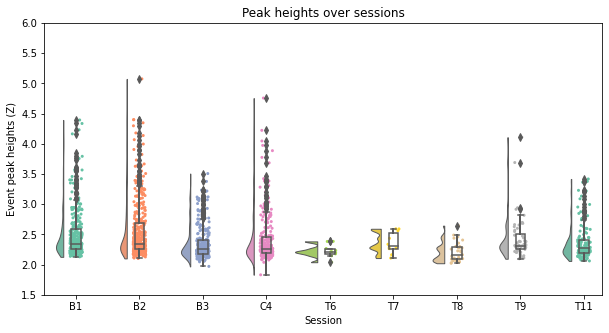

In [ ]:
# Usage with a list/np.array input
dx = np.concatenate(session_list)
dy = np.concatenate(ph_list)
f, ax = plt.subplots(figsize=(10, 5))
ax=pt.RainCloud(dx, dy)
plt.ylim(1.5,6)
plt.ylabel('Event peak heights (Z)')
plt.xlabel('Session')
plt.title('Peak heights over sessions')
x_label_list = ['B1','B2','B3','C4','T6','T7','T8','T9','T11']
ax.set_xticklabels(x_label_list)

[Text(0, 0, 'B1'),
 Text(1, 0, 'B2'),
 Text(2, 0, 'B3'),
 Text(3, 0, 'C4'),
 Text(4, 0, 'T6'),
 Text(5, 0, 'T7'),
 Text(6, 0, 'T8'),
 Text(7, 0, 'T9'),
 Text(8, 0, 'T11')]

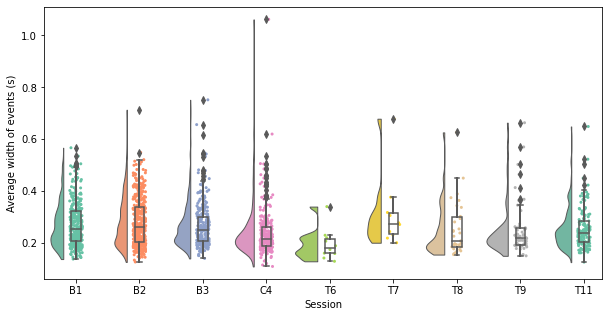

In [ ]:
# Usage with a list/np.array input
dx = np.concatenate(session_list)
dy = np.concatenate(widths_list)*0.0645
f, ax = plt.subplots(figsize=(10, 5))
ax=pt.RainCloud(dx, dy)

plt.ylabel('Average width of events (s)')
plt.xlabel('Session')
#plt.ylim(0,190)
x_label_list = ['B1','B2','B3','C4','T6','T7','T8','T9','T11']
ax.set_xticklabels(x_label_list)

In [ ]:
num_mice = simpledialog.askinteger("Number of animals","Number of animals:")